In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import datetime

file_path = '.\data13-1602-Main-ex.csv'
dataset = pd.read_csv(file_path, delimiter=',',header=0,skipinitialspace=True)
print(dataset)

                     time    tem   humi   pm25
0     2022-12-13 22:15:00  23.41  42.27  48.37
1     2022-12-13 22:45:00  22.38  43.17  38.29
2     2022-12-13 23:15:00  22.19  44.02  39.95
3     2022-12-14 00:45:00  21.53  48.36  29.66
4     2022-12-14 01:00:00  21.43  48.11  30.45
...                   ...    ...    ...    ...
5563  2023-02-16 16:00:00  20.24  50.59  37.39
5564  2023-02-16 16:15:00  20.24  51.12  34.28
5565  2023-02-16 16:30:00  20.09  48.89  41.95
5566  2023-02-16 16:45:00  19.85  50.17  34.46
5567  2023-02-16 17:00:01  19.67  50.22  36.62

[5568 rows x 4 columns]


In [27]:
date_time = pd.to_datetime(dataset["time"])
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [28]:
dataset.index = dataset['time']
del dataset['time']
print(dataset)

                       tem   humi   pm25
time                                    
2022-12-13 22:15:00  23.41  42.27  48.37
2022-12-13 22:45:00  22.38  43.17  38.29
2022-12-13 23:15:00  22.19  44.02  39.95
2022-12-14 00:45:00  21.53  48.36  29.66
2022-12-14 01:00:00  21.43  48.11  30.45
...                    ...    ...    ...
2023-02-16 16:00:00  20.24  50.59  37.39
2023-02-16 16:15:00  20.24  51.12  34.28
2023-02-16 16:30:00  20.09  48.89  41.95
2023-02-16 16:45:00  19.85  50.17  34.46
2023-02-16 17:00:01  19.67  50.22  36.62

[5568 rows x 3 columns]


In [29]:
n_train_rows = int(dataset.shape[0]*.8)-1
#n_test_rows = int(dataset.shape[0]*.9)-1

#80/20
train = dataset.iloc[:n_train_rows, :]
test = dataset.iloc[n_train_rows:, :]
#valid = dataset.iloc[n_test_rows:, :]


print(train.shape)
print(test.shape)
#print(valid.shape)


(4453, 3)
(1115, 3)


<AxesSubplot:>

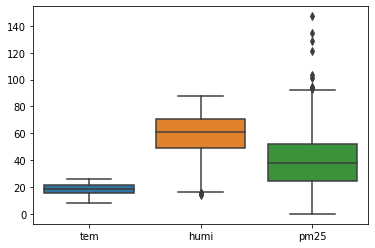

In [30]:
import seaborn as sns
sns.boxplot(data=train)

<AxesSubplot:>

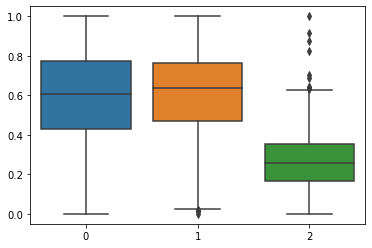

In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))


training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)
#valid_set_scaled = sc.fit_transform(valid.values)

sns.boxplot(data=training_set_scaled)

In [32]:
x_train = []
y_train = []

n_future = 4 # next 4 days temperature forecast 1 hour
steps = 48
input = 3
print(training_set_scaled.shape[0])

for i in range(steps, training_set_scaled.shape[0]-steps): #(48 -> 3286 - 48 = 3238)
    x_train.append(training_set_scaled[i-steps:i, :]) #(48 - 48: 48) = (0->47)
    y_train.append(training_set_scaled[i:i+n_future, 0:3]) #[48 51] 15*4 minutes

x_train, y_train = np.array(x_train), np.array(y_train)

#x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], input) )

print(x_train.shape)
print(y_train.shape)

4453
(4357, 48, 3)
(4357, 4, 3)


In [33]:
# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]-steps): # 48->822-48=774
    x_test.append(test_set_scaled[i-steps:i, :]) #48-48 -> 48 = 0 -> 47
    y_test.append(test_set_scaled[i:i+n_future, 0:3])   #48

x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)
print(test_set_scaled.shape)

(1019, 48, 3)
(1019, 4, 3)
(1115, 3)


In [34]:
# Prepare the test data
#x_valid = []
#y_valid = []

#for i in range(steps, valid_set_scaled.shape[0]-steps): # 48->775
#    x_valid.append(valid_set_scaled[i-steps:i, :]) #48-48 -> 48 = 0 -> 47
#    y_valid.append(valid_set_scaled[i:i+n_future, 0:3])   #48

#x_valid, y_valid = np.array(x_valid), np.array(y_valid)
#print(x_valid.shape)
#print(y_valid.shape)

In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Reshape
#from plot_model import plot_model
from keras.utils.vis_utils import plot_model


epochs = 125
optimize = 'adam'
# loss function 'mean_squared_error', 'root_mean_squared_error'
loss = 'mean_squared_error'
activation = 'linear'
metric = 'acc'
output_shape = [4,3]

print(x_train.shape)

model = Sequential()

model.add(LSTM(32,input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
#model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=3*4, return_sequences=False))
model.add(Dense(units=3*4, activation = activation)) # numfeat*outstep
model.add(Reshape(output_shape))

model.compile(optimizer = optimize, loss= loss , metrics=[metric])
model.summary()



(4357, 48, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 48, 32)            4608      
                                                                 
 lstm_3 (LSTM)               (None, 12)                2160      
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 reshape_1 (Reshape)         (None, 4, 3)              0         
                                                                 
Total params: 6,924
Trainable params: 6,924
Non-trainable params: 0
_________________________________________________________________


In [36]:
#history = model.fit(x_train, y_train, batch_size = 32, epochs = epochs, validation_data=(x_valid,y_valid))
history = model.fit(x_train, y_train, batch_size = 32, epochs = epochs, validation_split=0.2)

Epoch 1/125
109/109 [==============================] - 6s 24ms/step - loss: 0.0818 - acc: 0.6068 - val_loss: 0.0194 - val_acc: 0.5740
Epoch 2/125
109/109 [==============================] - 2s 17ms/step - loss: 0.0096 - acc: 0.8486 - val_loss: 0.0095 - val_acc: 0.6778
Epoch 3/125
109/109 [==============================] - 2s 17ms/step - loss: 0.0058 - acc: 0.8900 - val_loss: 0.0070 - val_acc: 0.8085
Epoch 4/125
109/109 [==============================] - 2s 17ms/step - loss: 0.0045 - acc: 0.9062 - val_loss: 0.0054 - val_acc: 0.7460
Epoch 5/125
109/109 [==============================] - 2s 16ms/step - loss: 0.0038 - acc: 0.9141 - val_loss: 0.0048 - val_acc: 0.8819
Epoch 6/125
109/109 [==============================] - 2s 17ms/step - loss: 0.0034 - acc: 0.9138 - val_loss: 0.0041 - val_acc: 0.8068
Epoch 7/125
109/109 [==============================] - 2s 16ms/step - loss: 0.0030 - acc: 0.9246 - val_loss: 0.0039 - val_acc: 0.9189
Epoch 8/125
109/109 [==============================] - 2s 16ms

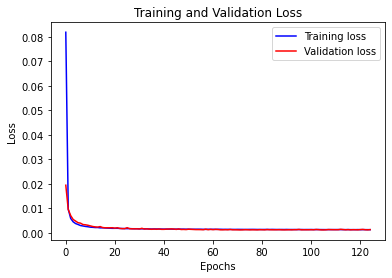

In [37]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [38]:
model.save("my_model.h5")

In [39]:
print(history.history.keys())


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


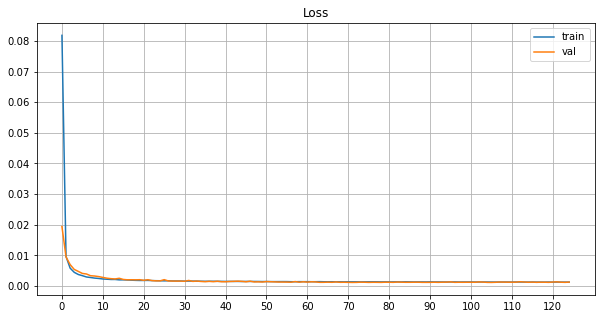

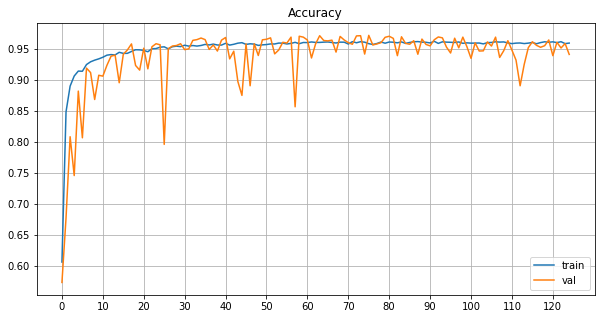

In [40]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,5))
#pyplot.figure(1)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xticks(np.arange(0, len(history.history['loss']), step=10))
pyplot.legend(['train', 'val'], loc='best')
pyplot.grid(True)
pyplot.show()
pyplot.figure(figsize=(10,5))
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.xticks(np.arange(0, len(history.history['acc']), step=10))
pyplot.legend(['train', 'val'], loc='best')
pyplot.grid(True)

pyplot.show()



In [41]:
print(y_test.shape)
print(y_test)

(1019, 4, 3)
[[[0.54330709 0.74921036 0.59916801]
  [0.49448819 0.79890503 0.55864198]
  [0.50393701 0.78963992 0.5240204 ]
  [0.49606299 0.79574647 0.43276973]]

 [[0.49448819 0.79890503 0.55864198]
  [0.50393701 0.78963992 0.5240204 ]
  [0.49606299 0.79574647 0.43276973]
  [0.48976378 0.80459044 0.462292  ]]

 [[0.50393701 0.78963992 0.5240204 ]
  [0.49606299 0.79574647 0.43276973]
  [0.48976378 0.80459044 0.462292  ]
  [0.57007874 0.75173721 0.55018787]]

 ...

 [[0.10551181 0.08254369 0.12144391]
  [0.10393701 0.10002106 0.15968867]
  [0.09606299 0.07180459 0.18625872]
  [0.0976378  0.08296483 0.17606012]]

 [[0.10393701 0.10002106 0.15968867]
  [0.09606299 0.07180459 0.18625872]
  [0.0976378  0.08296483 0.17606012]
  [0.0976378  0.09475679 0.14774557]]

 [[0.09606299 0.07180459 0.18625872]
  [0.0976378  0.08296483 0.17606012]
  [0.0976378  0.09475679 0.14774557]
  [0.09133858 0.08696568 0.15311326]]]


In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)

(4357, 48, 3)
(4357, 4, 3)
(1019, 48, 3)
(1019, 4, 3)

# Evaluate on test data
32/32 [==============================] - 0s 7ms/step - loss: 0.0051 - acc: 0.9225
test loss, test acc: [0.005053747445344925, 0.9224730134010315]


In [43]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(4357, 48, 3)
(4357, 4, 3)
(1019, 48, 3)
(1019, 4, 3)


In [44]:
from keras.models import load_model
import numpy as np  
mode = load_model('my_model.h5')

results2 = mode.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results2)

x = x_test[0:]
y_p = mode.predict(x)
#print(x_test)
#print(x_test.shape)
print(x.shape)
print(y_p.shape)
for i in range(y_p.shape[0]):
    y_p[i] = sc.inverse_transform(y_p[i])

print(y_p[1])
print(y_p.shape)


32/32 [==============================] - 1s 8ms/step - loss: 0.0051 - acc: 0.9225
test loss, test acc: [0.005053747445344925, 0.9224730134010315]
32/32 [==============================] - 1s 6ms/step
(1019, 48, 3)
(1019, 4, 3)
[[23.297619 78.46892  58.95589 ]
 [23.277254 78.37872  58.02991 ]
 [23.31128  78.24886  57.82637 ]
 [23.438263 78.36566  57.75159 ]]
(1019, 4, 3)


In [45]:
#x = test DF
#y_p = predict

dt = y_p.reshape(y_p.shape[0]*y_p.shape[1],3) # 3d to 2d

#print(dt)
#print(dt)
print(len(dt))
dataF = []
for i in range(0,len(dt),4):
    dataF.append(dt[i])

dataG = pd.DataFrame(dataF,columns=['tem','humi','pm25'])
#data G = parser data Predict step = 4


4076


In [46]:
print(dt[4])
print(dataG)

[23.297619 78.46892  58.95589 ]
            tem       humi       pm25
0     23.347837  78.657349  59.257290
1     23.297619  78.468918  58.955891
2     22.886482  80.940628  58.153465
3     22.948296  80.530258  57.266151
4     22.877256  80.762474  54.348057
...         ...        ...        ...
1014  20.310690  51.497547  27.894684
1015  20.295086  51.333286  27.275837
1016  20.291927  51.247921  26.644737
1017  20.306353  51.004894  26.090427
1018  20.291882  51.159481  26.116770

[1019 rows x 3 columns]


In [47]:
DFdataset = test
DFdataset.shape
test.shape


(1115, 3)

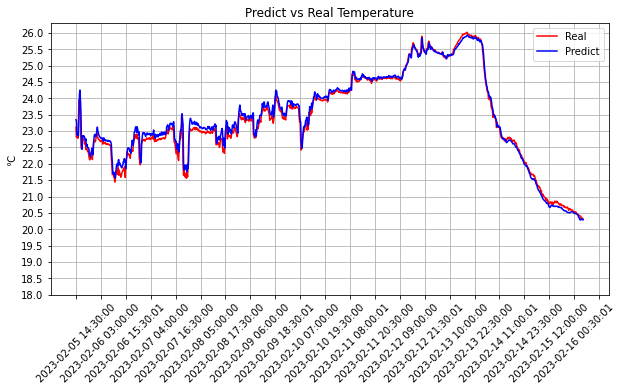

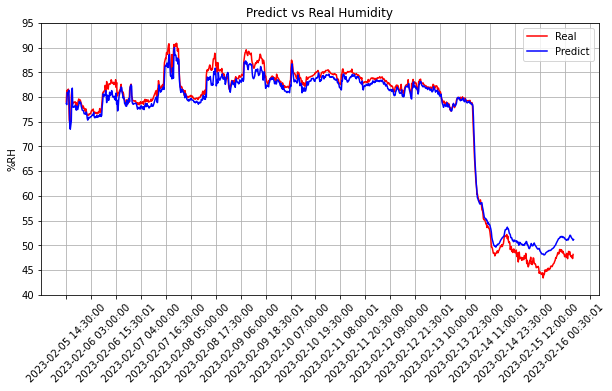

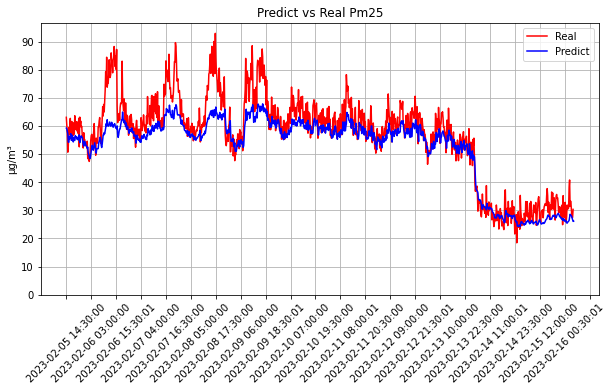

In [48]:
y_test = test.reset_index()

real = DFdataset[48:1018+48]
#real.append(dfdt1,ignore_index=True)
# Visualise the ask_price predictions
plt.figure(figsize = (10,5))
plt.plot(real['tem'], color = 'red', label = 'Real')
plt.plot(dataG['tem'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Temperature')
plt.xticks(np.arange(0, 1100, step=50))
plt.xticks(rotation=45)
plt.yticks(np.arange(18, 26.5, step=0.5))
plt.ylabel('℃')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(real['humi'], color = 'red', label = 'Real')
plt.plot(dataG['humi'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Humidity')
plt.xticks(np.arange(0, 1100, step=50))
plt.xticks(rotation=45)
plt.yticks(np.arange(40, 100, step=5))
plt.ylabel('%RH')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(real['pm25'], color = 'red', label = 'Real')
plt.plot(dataG['pm25'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Pm25')
plt.xticks(np.arange(0, 1100, step=50))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 100, step=10))
plt.ylabel('µg/m³')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
Data_1h = y_p[0]
print(Data_1h)
data_1hdf = pd.DataFrame(Data_1h,columns=['tem','humi','pm25'])
print(data_1hdf)

[[23.347837 78.65735  59.25729 ]
 [23.322088 78.4274   58.27902 ]
 [23.36612  78.294014 58.20399 ]
 [23.491493 78.42058  57.95406 ]]
         tem       humi       pm25
0  23.347837  78.657349  59.257290
1  23.322088  78.427399  58.279018
2  23.366119  78.294014  58.203991
3  23.491493  78.420578  57.954060


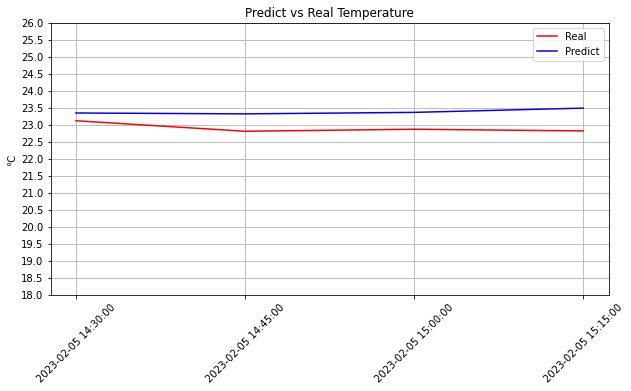

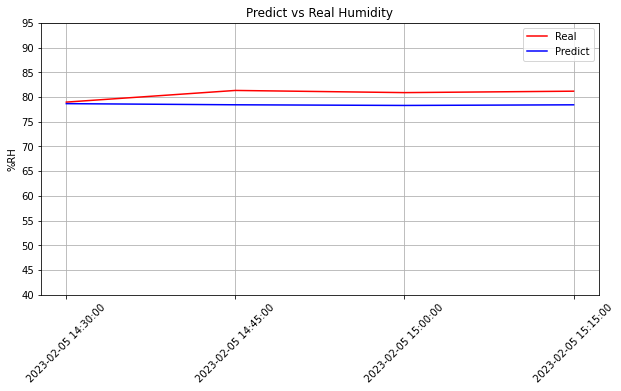

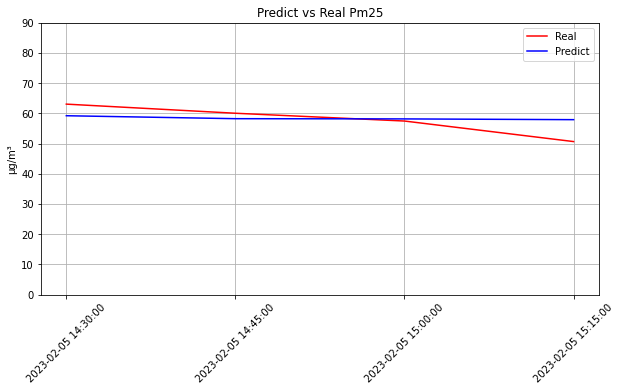

In [50]:
real1h = DFdataset[48:52]
#real.append(dfdt1,ignore_index=True)
# Visualise the ask_price predictions
plt.figure(figsize = (10,5))
plt.plot(real1h['tem'], color = 'red', label = 'Real')
plt.plot(data_1hdf['tem'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Temperature')
plt.xticks(np.arange(0, 4, step=1))
plt.xticks(rotation=45)
plt.yticks(np.arange(18, 26.5, step=0.5))
plt.ylabel('℃')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(real1h['humi'], color = 'red', label = 'Real')
plt.plot(data_1hdf['humi'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Humidity')
plt.xticks(np.arange(0, 4, step=1))
plt.xticks(rotation=45)
plt.yticks(np.arange(40, 100, step=5))
plt.ylabel('%RH')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize = (10,5))
plt.plot(real1h['pm25'], color = 'red', label = 'Real')
plt.plot(data_1hdf['pm25'], color = 'blue', label = 'Predict')
plt.title('Predict vs Real Pm25')
plt.xticks(np.arange(0, 4, step=1))
plt.xticks(rotation=45)
plt.yticks(np.arange(0, 100, step=10))
plt.ylabel('µg/m³')
plt.legend()
plt.grid(True)
plt.show()
